In [39]:
#import libraries needed
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import geocoder # import geocoder
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library
#set jupiter to widescreen
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))



In [2]:
#Initialize Foursquare credentials
CLIENT_ID = 'X4SJA3AV3FTZ22OEQXP55EHFQLTOUCZKGTSCC5F2JOQO501J' # your Foursquare ID
CLIENT_SECRET = 'MYAZ3IBXZRWJZR1PDTQONDIHCM13IRJDI12TFEUQFEFZQADG' # your Foursquare Secret
ACCESS_TOKEN = '45U4RLZCPAHXURFJBXLSCVEMY1R3IBZYIJT1ELCAM1D5PPJV' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: X4SJA3AV3FTZ22OEQXP55EHFQLTOUCZKGTSCC5F2JOQO501J
CLIENT_SECRET:MYAZ3IBXZRWJZR1PDTQONDIHCM13IRJDI12TFEUQFEFZQADG


In [3]:
#get html doc of postal codes, burroughs and neighborhoods
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(url, 'html5lib').text
#  check for get r.text
#create soup object
soup = BeautifulSoup(r)
#print(soup.prettify())


In [4]:
#Isolate cells of table and create dataframe
table_contents = []
table = soup.find('table')
for row in table.findAll('td'):
    cell = {}
    #remove not assigned
    if row.span.text == 'Not assigned':
        pass
    else:
        #get first 3 characters of text as postalcode
        cell['PostalCode'] = row.p.text[:3]
        #get text split by '(' and place first item in Borough
        cell['Borough'] = (row.span.text).split('(')[0]
        #get text split by '(' and place second item in Neighborhood, then remove '(,)' and replace '/' with ','
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace('/',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
#print(table_contents)
df = pd.DataFrame(table_contents)
#clean up formatting 
df['Borough'] = df['Borough'].replace({'Downtown TorontoStn A PO Bosxes25 The Esplande' : 'Downtown Toronto Stn A',
                                      'East TorontoBusiness reply mail Processing Centre969 Eastern' : 'East Toronto Business',
                                      'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto': 'East York/East Toronto',
                                      'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
    



In [35]:
#initialize postal_code variable
postal_code = df['PostalCode']
#loop for finding and appending lat and long based on postal codes
# Using while Statement
latitude = []
longitude = []
n = 0

while n < len(postal_code):
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code[n]))
    lat_lng_coords = g.latlng
    print('The gps coordinates of {} are {}, {}.'.format(postal_code[n], lat_lng_coords[0], lat_lng_coords[1]))
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])
    n = n + 1

df['Latitude'] = latitude
df['Longitude'] = longitude

df.head(12)



The gps coordinates of M3A are 43.75245000000007, -79.32990999999998.
The gps coordinates of M4A are 43.73057000000006, -79.31305999999995.
The gps coordinates of M5A are 43.65512000000007, -79.36263999999994.
The gps coordinates of M6A are 43.72327000000007, -79.45041999999995.
The gps coordinates of M7A are 43.66253000000006, -79.39187999999996.
The gps coordinates of M9A are 43.662630000000036, -79.52830999999998.
The gps coordinates of M1B are 43.811390000000074, -79.19661999999994.
The gps coordinates of M3B are 43.74923000000007, -79.36185999999998.
The gps coordinates of M4B are 43.70718000000005, -79.31191999999999.
The gps coordinates of M5B are 43.65739000000008, -79.37803999999994.


KeyboardInterrupt: 

In [36]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.72327,-79.45042
4,M7A,Queen's Park,Ontario Provincial Government,43.66253,-79.39188


In [40]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
display(map_toronto)

In [6]:
#Function to pull venue information about each postal code
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
#make a 1d list of each item and append to columns
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
#create new object with dataframe of pulled data from foursquare
toronto_venues = getNearbyVenues(names = df['Neighborhood'],
                                 latitudes = df['Latitude'],
                                 longitudes = df['Longitude']
                                 )

Parkwoods
Victoria Village
Regent Park , Harbourfront
Lawrence Manor , Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern , Rouge
Don Mills North
Parkview Hill , Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park , Princess Gardens , Martin Grove , Islington , Cloverdale
Rouge Hill , Port Union , Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate , Bloordale Gardens , Old Burnhamthorpe , Markland Wood
Guildwood , Morningside , West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor , Wilson Heights , Downsview North
Thorncliffe Park
Richmond , Adelaide , King
Dufferin , Dovercourt Village
Scarborough Village
Fairview , Henry Farm , Oriole
Northwood Park , York University
The Danforth  East
Harbourfront East , Union Station , Toronto Islands
Little Portugal , Trinity
Kennedy Park , Ionview , East Birchmount Park
Bayview Village

In [8]:
#Check dataframe
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.75245,-79.32991,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.75245,-79.32991,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.75245,-79.32991,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,Victoria Village,43.73057,-79.31306,Wigmore Park,43.731023,-79.310771,Park
4,Victoria Village,43.73057,-79.31306,Memories of Africa,43.726602,-79.312427,Grocery Store


In [9]:
#How many venues in each neighborhood
toronto_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,15,15,15,15,15,15
"Alderwood , Long Branch",4,4,4,4,4,4
"Bathurst Manor , Wilson Heights , Downsview North",2,2,2,2,2,2
Bayview Village,4,4,4,4,4,4
"Bedford Park , Lawrence Manor East",20,20,20,20,20,20
...,...,...,...,...,...,...
Willowdale West,4,4,4,4,4,4
Woburn,5,5,5,5,5,5
Woodbine Heights,18,18,18,18,18,18


In [10]:
#how many unique categories of venue?
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))


There are 265 unique categories.


NameError: name 'toronto_onehot' is not defined

In [11]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
#Replace Neighborhood column
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
#locate neighborhood
neigh_loc = toronto_onehot.columns.get_loc('Neighborhood')
#move Neighborhood to front
fixed_columns = [toronto_onehot.columns[neigh_loc]] + list(toronto_onehot.columns)
toronto_onehot = toronto_onehot[fixed_columns]
#dropping duplicate ['Neighborhood']
toronto_onehot = toronto_onehot.loc[:,~toronto_onehot.columns.duplicated()]

toronto_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#Find mean occurence of each category ie scale
toronto_grouped = toronto_onehot.groupby(['Neighborhood']).mean()
toronto_grouped.reset_index(inplace = True)
toronto_grouped

,Neighborhood,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0
1,"Alderwood , Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor , Wilson Heights , Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park , Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
96,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
97,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
98,"York Mills , Silver Hills",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [13]:
toronto_grouped.shape


(100, 265)

In [14]:
#function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Hong Kong Restaurant,Badminton Court,Department Store,Discount Store,Newsagent,Shopping Mall,Skating Rink,Supermarket,Sushi Restaurant
1,"Alderwood , Long Branch",Convenience Store,Athletics & Sports,Pub,Gym,Noodle House,Nightclub,Newsagent,New American Restaurant,Music Venue,Museum
2,"Bathurst Manor , Wilson Heights , Downsview North",Home Service,Men's Store,Office,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target
3,Bayview Village,Trail,Construction & Landscaping,Park,ATM,Museum,Nightclub,Newsagent,New American Restaurant,Music Venue,Moving Target
4,"Bedford Park , Lawrence Manor East",Sandwich Place,Coffee Shop,Italian Restaurant,Comfort Food Restaurant,Juice Bar,Liquor Store,Fast Food Restaurant,Restaurant,Thai Restaurant,Greek Restaurant


In [27]:
toronto_grouped_clustering = toronto_grouped
toronto_grouped_clustering.reset_index(drop = True, inplace = True)
toronto_grouped_clustering.drop(['Neighborhood'], axis = 1, inplace = True)
toronto_grouped_clustering

,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [28]:
#Finding K
Sum_of_squared_distances = []
K = range(1,100)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)


G:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
<ipython-input-28-8cdcd1bb8061>:6: ConvergenceWarning: Number of distinct clusters (97) found smaller than n_clusters (98). Possibly due to duplicate points in X.
  km = km.fit(toronto_grouped_clustering)
<ipython-input-28-8cdcd1bb8061>:6: ConvergenceWarning: Number of distinct clusters (97) found smaller than n_clusters (99). Possibly due to duplicate points in X.
  km = km.fit(toronto_grouped_clustering)


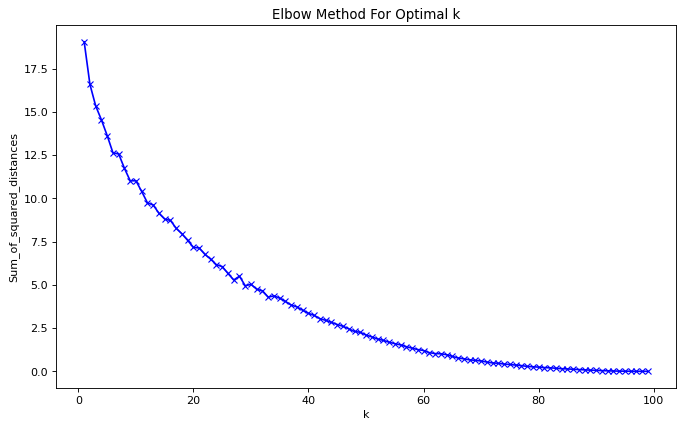

In [29]:
figure(figsize = (10,6), dpi = 80)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [30]:
# set number of clusters
kclusters = 35

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([34, 32,  3, 24,  2,  2, 28,  2,  2, 34])

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_venues

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,43.75245,-79.32991,Brookbanks Park,43.751976,-79.332140,Park,33,Food & Drink Shop,Construction & Landscaping,Park,Moving Target,Nightclub,Newsagent,New American Restaurant,Music Venue,Museum,Movie Theater
1,Parkwoods,43.75245,-79.32991,Variety Store,43.751974,-79.333114,Food & Drink Shop,33,Food & Drink Shop,Construction & Landscaping,Park,Moving Target,Nightclub,Newsagent,New American Restaurant,Music Venue,Museum,Movie Theater
2,Parkwoods,43.75245,-79.32991,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping,33,Food & Drink Shop,Construction & Landscaping,Park,Moving Target,Nightclub,Newsagent,New American Restaurant,Music Venue,Museum,Movie Theater
3,Victoria Village,43.73057,-79.31306,Wigmore Park,43.731023,-79.310771,Park,11,Grocery Store,Park,ATM,Museum,Nightclub,Newsagent,New American Restaurant,Music Venue,Moving Target,Office
4,Victoria Village,43.73057,-79.31306,Memories of Africa,43.726602,-79.312427,Grocery Store,11,Grocery Store,Park,ATM,Museum,Nightclub,Newsagent,New American Restaurant,Music Venue,Moving Target,Office


In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

AttributeError: 'Map' object has no attribute '_build_map'